# DASHBOARD
__This notebook is meant setup a training session and evaluate its performances__

----

Load python libraries

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session, get_session
import keras.losses as klosses
import keras.optimizers as koptimizers
import keras.callbacks as kcallbacks
import keras.initializers as initializers

Using TensorFlow backend.


Load and setup local dependencies

In [2]:
cur_dir = os.getcwd()
base_dir = os.path.dirname(cur_dir)

import sys
sys.path.append(base_dir)
from utils.LungsLoader import LungsLoader
from utils.ScanHandler import ScanHandler

import src.losses as reg_losses
from src.callbacks import OutputObserver
from src.training.config_file import ConfigFile
from src.training.luna_training import LunaTrainer
from src.evaluation.luna_testing import LunaTester

import warnings
warnings.filterwarnings("ignore")

loader = LungsLoader()
handler = ScanHandler(plt)

/Users/dieze/Documents/OMA/TheraPanacea/thera_reg_oma/utils/LungsLoader.py:35: UserWarning: Subset folder 0 not found in data.
  warnings.warn(f"Subset folder {subset_f[-1:]} not found in data.")
/Users/dieze/Documents/OMA/TheraPanacea/thera_reg_oma/utils/LungsLoader.py:35: UserWarning: Subset folder 1 not found in data.
  warnings.warn(f"Subset folder {subset_f[-1:]} not found in data.")
/Users/dieze/Documents/OMA/TheraPanacea/thera_reg_oma/utils/LungsLoader.py:35: UserWarning: Subset folder 2 not found in data.
  warnings.warn(f"Subset folder {subset_f[-1:]} not found in data.")
/Users/dieze/Documents/OMA/TheraPanacea/thera_reg_oma/utils/LungsLoader.py:35: UserWarning: Subset folder 3 not found in data.
  warnings.warn(f"Subset folder {subset_f[-1:]} not found in data.")
/Users/dieze/Documents/OMA/TheraPanacea/thera_reg_oma/utils/LungsLoader.py:35: UserWarning: Subset folder 4 not found in data.
  warnings.warn(f"Subset folder {subset_f[-1:]} not found in data.")
/Users/dieze/Documen

# Initialize a session

In [4]:
session_name = "atlas_cc_reg5"
config = ConfigFile(session_name)
config.setup_session()

# Build the model

In [5]:
from src.networks.networks_utils import blocks
from src.networks.MariaNet import MariaNet
from src.networks.DiffeomorphicUnet import DiffeomorphicUnet

__Setting up model hyperparameters :__

In [5]:
# MARIA NET HYPERPARAMETERS
input_shape = (64, 64, 64)

conv_block_kwgs = {
                    "activation": "LeakyReLU",
                    "activation_kwargs":{
                        "alpha": 0.3
                        },
                    "normalize": True,
                    "conv_kwargs": {
                      "kernel_size": 3,
                      "padding": "same",
                      "kernel_initializer": initializers.RandomNormal(mean=0.0, stddev=1e-5)
                      }
                    }
squeeze_ratio = 16
conv_block = blocks.ConvBlock(**conv_block_kwgs)
squeeze_block = blocks.SqueezeExciteBlock(ratio=squeeze_ratio)

enc_filters = [32, 64, 128, 32, 32]
enc_dilation = [(1, 1, 1), (1, 1, 1), (2, 2, 2), (3, 3, 3), (5, 5, 5)]
enc_params = [{"filters": n_filter, "dilation_rate": dil_rate} for (n_filter, dil_rate) in zip(enc_filters, enc_dilation)]

dec_filters = [128, 64, 32, 32, 32]
dec_params = [{"filters": n_filter} for n_filter in dec_filters]

def_flow_nf = 3
lin_flow_nf = 12

builder = MariaNet(input_shape=input_shape,
                   enc_params=enc_params,
                   dec_params=dec_params,
                   conv_block=conv_block,
                   squeeze_block=squeeze_block,
                   def_flow_nf=def_flow_nf,
                   lin_flow_nf=lin_flow_nf)

In [6]:
# UNET HYPERPARAMETERS
input_shape = (256, 256, 256)

conv_block_kwgs = {
                    "activation": "LeakyReLU",
                    "activation_kwargs":{
                        "alpha": 0.3
                        },
                    "normalize": True,
                    "conv_kwargs": {
                      "kernel_size": 3,
                      "padding": "same",
                      "kernel_initializer": initializers.RandomNormal(mean=0.0, stddev=1e-5)
                      }
                    }
conv_block = blocks.ConvBlock(**conv_block_kwgs)

enc_filters = [16, 32, 32, 32]

dec_filters = [32, 32, 32, 32, 16, 16]

flow_nf = 3

builder = DiffeomorphicUnet(input_shape=input_shape,
                            enc_nf=enc_filters,
                            dec_nf=dec_filters,
                            conv_block=conv_block,
                            flow_nf=flow_nf)

__Serialize model builder__

In [7]:
builder_path = os.path.join(config.session_dir, "builder.pickle")
builder.serialize(builder_path)

# Training parameters

__Training, validation, testing sets :__

In [8]:
all_ids = loader.get_scan_ids()
all_ids = all_ids[:167]
train_ids, val_ids = train_test_split(all_ids, test_size=0.4, random_state=777)
val_ids, test_ids = train_test_split(val_ids, test_size=0.5, random_state=777)

atlas_id = train_ids[39]
config.set_atlas_id(atlas_id)

pd.DataFrame(train_ids).to_csv(os.path.join(config.session_dir, LunaTrainer.train_ids_filename), index=False, header=False)
pd.DataFrame(val_ids).to_csv(os.path.join(config.session_dir, LunaTrainer.val_ids_filename), index=False, header=False)
pd.DataFrame(test_ids).to_csv(os.path.join(config.session_dir, LunaTester.test_ids_filename), index=True, header=False)

__Input Shape :__

In [9]:
config.set_input_shape(input_shape)

__Losses :__

In [5]:
losses = [reg_losses.cross_correlation, klosses.mean_absolute_error]
loss_weights = [1., 1e-5]

config.set_losses(losses)
config.set_loss_weights(loss_weights)

__Optimizer :__

In [11]:
optimizer = koptimizers.Adam(lr=1e-3, decay=1e-6)
config.set_optimizer(optimizer)

__Callbacks :__

In [13]:
checkpoints_dir = os.path.join(config.session_dir, ConfigFile.checkpoints_dirname)
observations_dir = os.path.join(config.session_dir, ConfigFile.observations_dirname)

save_callback = kcallbacks.ModelCheckpoint(os.path.join(checkpoints_dir, ConfigFile.checkpoints_format), 
                                           verbose=1, 
                                           save_best_only=False)
early_stopping = kcallbacks.EarlyStopping(monitor='loss',
                                          min_delta=1e-3,
                                          patience=20,
                                          mode='auto')
observer = OutputObserver(session_dir=config.session_dir,
                          input_shape=config.input_shape,
                          src_id=train_ids[24],
                          tgt_id=config.atlas_id,
                          use_segmentation=False,
                          src_filepath=ConfigFile.observations_format['src'],
                          tgt_filepath=ConfigFile.observations_format['tgt'],
                          pred_filepath=ConfigFile.observations_format['pred'],
                          grad_x_filepath=ConfigFile.observations_format['grad_x'],
                          grad_y_filepath=ConfigFile.observations_format['grad_y'],
                          pred_seg_filepath=ConfigFile.observations_format['pred_seg'])

callbacks = [save_callback, early_stopping, observer]
config.set_callbacks(callbacks)

__Training scope :__

In [14]:
config.set_initial_epoch(0)

In [15]:
epochs = 200
steps_per_epoch = len(train_ids)


config.set_epochs(epochs)
config.set_steps_per_epoch(steps_per_epoch)

__Serialize session configs__

In [6]:
config.serialize()

------------

# Monitoring

Choose session to monitor

In [3]:
session_name = "sandbox_session"
config = ConfigFile(session_name)

config_path = os.path.join(ConfigFile.bin_dir, session_name, ConfigFile.pickle_filename)
config.load(config_path)

Build model

In [4]:
from src.networks.MariaNet import MariaNet
from src.networks.DiffeomorphicUnet import DiffeomorphicUnet
builder = DiffeomorphicUnet()
builder.load(os.path.join(config.session_dir, ConfigFile.builder_filename))

In [10]:
model = builder.build()

weights_path = os.path.join(config.session_dir, ConfigFile.checkpoints_dirname, "chkpt_90.h5")
# model.load_weights(weights_path)

#### Visualization

> Training set

In [5]:
train_ids_path = os.path.join(config.session_dir, LunaTrainer.train_ids_filename)
train_ids = pd.read_csv(train_ids_path).values.squeeze()

In [44]:
scans_ids = random.choices(train_ids, k=2)

preproc_gen = loader.preprocess_scans([train_ids[3]], *config.input_shape, clipping=True)
# atlas_gen = loader.preprocess_scans([config.atlas_id], *config.input_shape, clipping=True)
# atlas_seg = loader.preprocess_segmentations(scans_ids, *config.input_shape)
src_tr = next(preproc_gen)[0][np.newaxis, :, :, :, np.newaxis]
# tgt_tr = next(preproc_gen)[0][np.newaxis, :, :, :, np.newaxis]
# tgt_seg_tr = next(atlas_seg)[0][np.newaxis, :, :, :, np.newaxis]

# [pred_tgt_tr, deform_field_tr, pred_tgt_seg_tr] = model.predict([src_tr, tgt_tr, tgt_seg_tr]) 

<Figure size 432x288 with 0 Axes>

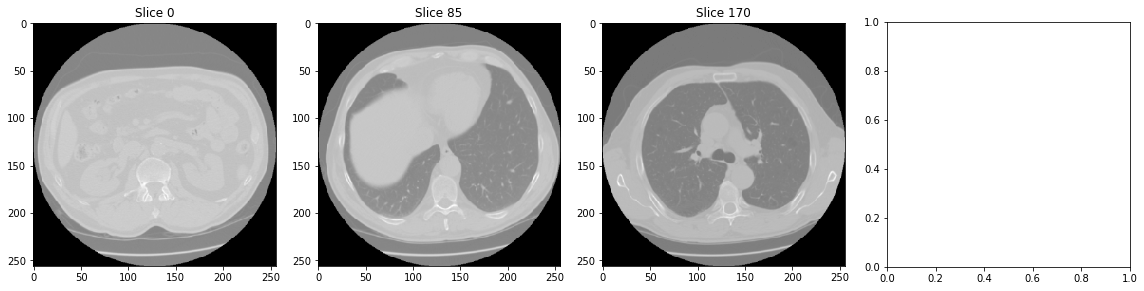

<Figure size 432x288 with 0 Axes>

In [43]:
handler.display_n_slices(src_tr.squeeze(), n=3)

<Figure size 432x288 with 0 Axes>

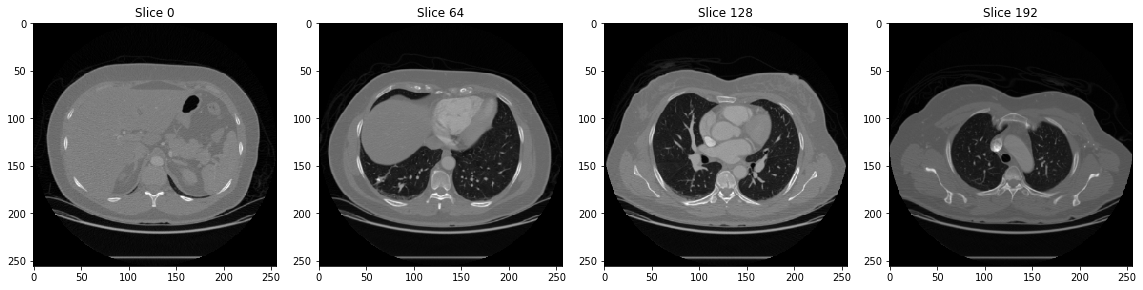

<Figure size 432x288 with 0 Axes>

In [28]:
handler.display_n_slices(tgt_tr.squeeze(), n=4)

> Testing set

In [7]:
test_ids_path = os.path.join(config.session_dir, LunaTester.test_ids_filename)
test_ids = pd.read_csv(test_ids_path).values.squeeze()

In [69]:
scans_ids = random.choices([test_ids[24]], k=1)

preproc_gen = loader.preprocess_scans(scans_ids, *config.input_shape, clipping=True)
atlas_gen = loader.preprocess_scans([config.atlas_id], *config.input_shape, clipping=True)

src_te = next(preproc_gen)[0][np.newaxis, :, :, :, np.newaxis]
tgt_te = next(atlas_gen)[0][np.newaxis, :, :, :, np.newaxis]

[pred_tgt_te, deform_field_tr] = model.predict([src_te, tgt_te]) 

<Figure size 432x288 with 0 Axes>

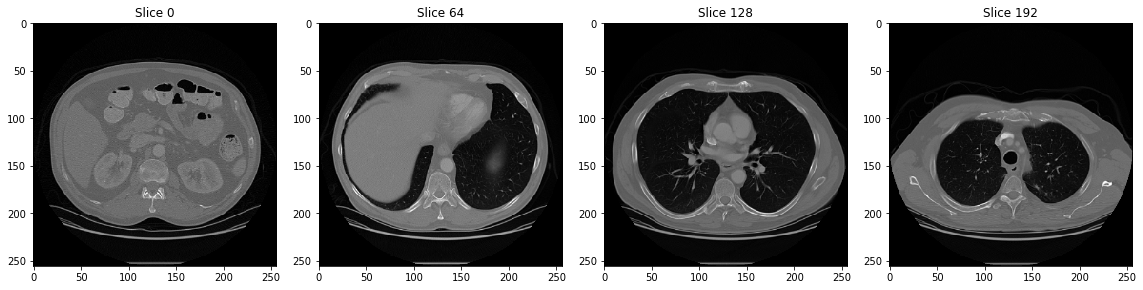

<Figure size 432x288 with 0 Axes>

In [70]:
handler.display_n_slices(src_te.squeeze(), n=4)

<Figure size 432x288 with 0 Axes>

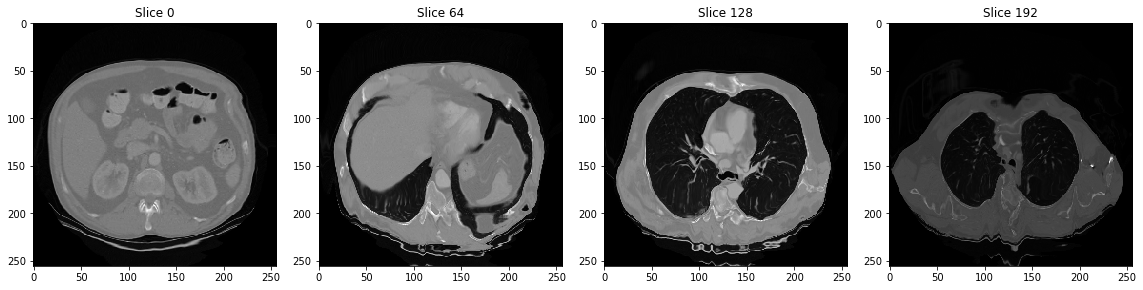

<Figure size 432x288 with 0 Axes>

In [71]:
handler.display_n_slices(pred_tgt_te.squeeze(), n=4)

<Figure size 432x288 with 0 Axes>

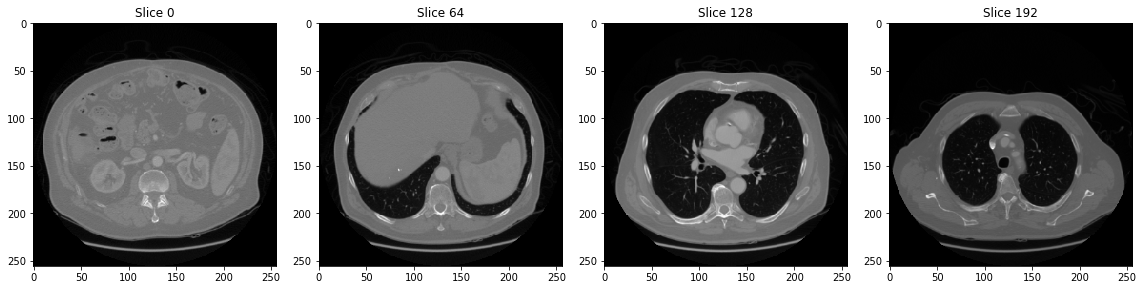

<Figure size 432x288 with 0 Axes>

In [72]:
handler.display_n_slices(tgt_te.squeeze(), n=4)

__Testing:__

In [3]:
import importlib
import src.evaluation.luna_testing

# # Setup device
# gpu_id = 1
# gpu = '/gpu:' + str(gpu_id)
# os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)
# tf_config = tf.ConfigProto()
# tf_config.gpu_options.allow_growth = True
# tf_config.allow_soft_placement = True
# set_session(tf.Session(config=tf_config))
# get_session().run(tf.global_variables_initializer())

In [4]:
importlib.reload(src.evaluation.luna_testing)

<module 'src.evaluation.luna_testing' from '/workspace/thera_reg_oma/src/evaluation/luna_testing.py'>

In [12]:
test_metrics = LunaTester.reg_metrics

tester = src.evaluation.luna_testing.LunaTester(model=model,
                    device=0,
                    config_path=config_path,
                    weights_path=weights_path,
                    reg_metric_dict=LunaTester.reg_metrics,
                    seg_metric_dict=LunaTester.seg_metrics)

In [13]:
scores = tester.evaluate(train_ids, filename="train_scores.csv", generator="atlas_seg")

Number of testing scans : 98

********** Beginning evaluation **********



atlas_seg_generator


Evaluated 0/98 scans

Evaluated 1/98 scans

Evaluated 2/98 scans

Evaluated 3/98 scans

Evaluated 4/98 scans

Evaluated 5/98 scans

Evaluated 6/98 scans

Evaluated 7/98 scans

Evaluated 8/98 scans

Evaluated 9/98 scans

Evaluated 10/98 scans

Evaluated 11/98 scans

Evaluated 12/98 scans

Evaluated 13/98 scans

Evaluated 14/98 scans

Evaluated 15/98 scans

Evaluated 16/98 scans

Evaluated 17/98 scans

Evaluated 18/98 scans

Evaluated 19/98 scans

Evaluated 20/98 scans

Evaluated 21/98 scans

Evaluated 22/98 scans

Evaluated 23/98 scans

Evaluated 24/98 scans

Evaluated 25/98 scans

Evaluated 26/98 scans

Evaluated 27/98 scans

Evaluated 28/98 scans

Evaluated 29/98 scans

Evaluated 30/98 scans

Evaluated 31/98 scans

Evaluated 32/98 scans

Evaluated 33/98 scans

Evaluated 34/98 scans

Evaluated 35/98 scans

Evaluated 36/98 scans

Evaluated 37/98 scans

Evaluated 38/98 scans

Evaluated 39/98 scans

Evaluated 40/98 scans

Evaluated 41/98 scans

Evaluated 42/98 scans

Evaluated 43/98 scans

## Score vis

In [110]:
import seaborn as sns

In [111]:
session_name = "atlas_unet_reg6"
config = ConfigFile(session_name)

config_path = os.path.join(ConfigFile.bin_dir, session_name, ConfigFile.pickle_filename)
config.load(config_path)

In [14]:
train_scores = pd.read_csv(os.path.join(config.session_dir, 
                                        ConfigFile.scores_dirname,
                                        LunaTester.train_scores_filename), index_col=0)
test_scores = pd.read_csv(os.path.join(config.session_dir, 
                                       ConfigFile.scores_dirname,
                                       LunaTester.test_scores_filename), index_col=0)

In [15]:
train_scores.drop_duplicates().mean()

mse                   0.269321
cross_correlation     0.545588
dice                  0.896459
haussdorf            95.853924
dtype: float64

In [17]:
test_scores.drop_duplicates().mean()

mse                   0.263301
cross_correlation     0.560444
dice                  0.899199
haussdorf            95.492649
dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f99f4365da0>,
      dtype=object)

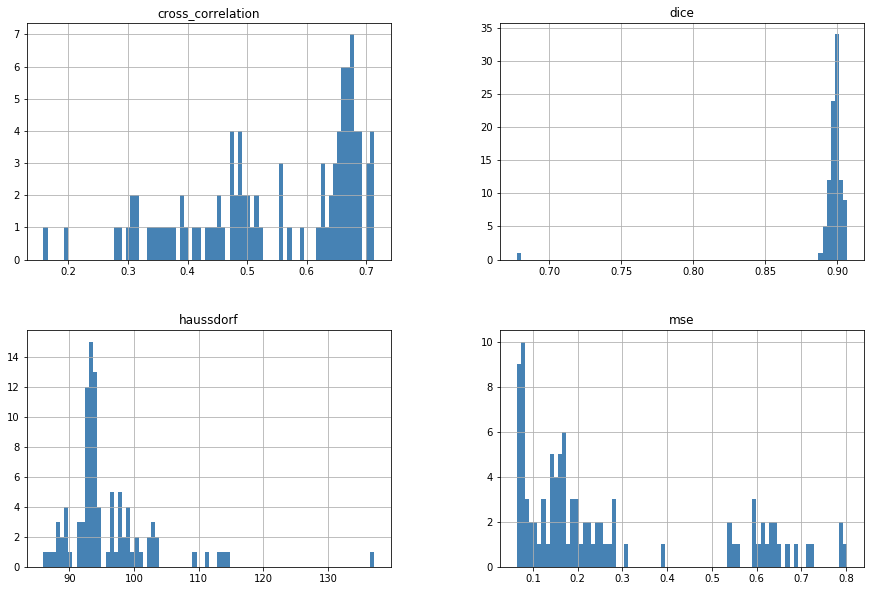

In [18]:
train_scores.drop_duplicates().hist(figsize=(15, 10), color="steelblue", bins=80)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f632a7d8518>,
      dtype=object)

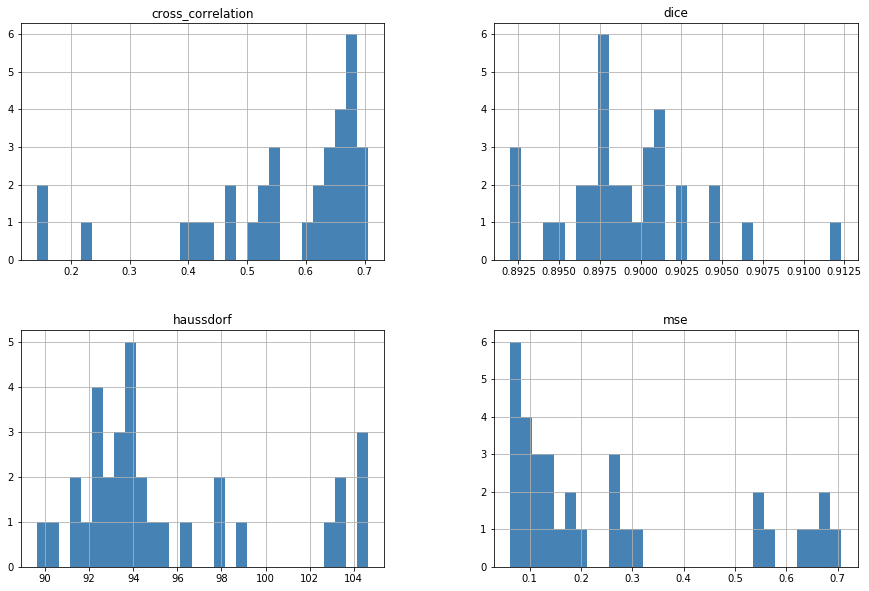

In [114]:
test_scores.drop_duplicates().hist(figsize=(15, 10), color="steelblue", bins=30)